In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


In [3]:
# data cleaning
tycho = pd.read_csv("project_tycho.csv")

tycho.head()
tycho.dtypes

# season column
tycho["week"] = tycho["epi_week"] % 100

def week_to_season(week):
    if week in range(1, 10) or week in range(50, 53):
        return "winter"
    elif week in range(10, 23):
        return "spring"
    elif week in range(23, 36):
        return "summer"
    elif week in range(36, 50):
        return "fall"
    
tycho["season"] = tycho["week"].apply(week_to_season)

# year column
tycho["year"] = tycho["epi_week"].astype(str).str[:4].astype(int)

# risk level
percentile75 = tycho["incidence_per_100000"].quantile(0.75)

def incidence_to_risk(incidence):
    if incidence > percentile75:
        return "high"
    else:
        return "low"
    
tycho["risk"] = tycho["incidence_per_100000"].apply(incidence_to_risk)

# split into df for each disease
dfs = {disease: sub_df for disease, sub_df in tycho.groupby('disease')}

hepA_df = dfs["HEPATITIS A"]
measles_df = dfs["MEASLES"]
mumps_df = dfs["MUMPS"]
pertussis_df = dfs["PERTUSSIS"]
polio_df = dfs["POLIO"]
rubella_df = dfs["RUBELLA"]
smallpox_df = dfs["SMALLPOX"]
dip_df = dfs["DIPHTHERIA"]

# split measles at 1970 (vaccine released in 1963 and improved in 1968)
measles_pre_split = measles_df[measles_df["year"] < 1970]
measles_post_split = measles_df[measles_df["year"] >= 1970]

/var/folders/lf/bm_19l6x73l1h3__7m5px25h0000gn/T/ipykernel_80132/51531348.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tycho = pd.read_csv("project_tycho.csv")


/var/folders/lf/bm_19l6x73l1h3__7m5px25h0000gn/T/ipykernel_80132/370781723.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["state"] = X["state"].astype("category")  # Convert to categorical if not already
/var/folders/lf/bm_19l6x73l1h3__7m5px25h0000gn/T/ipykernel_80132/370781723.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["state"] = X["state"].cat.reorder_categories(


Optimization terminated successfully.
         Current function value: 0.611874
         Iterations 5
Accuracy: 0.67
Precision: 0.64
Recall: 0.59
F1 Score: 0.62
AUC-ROC: 0.73


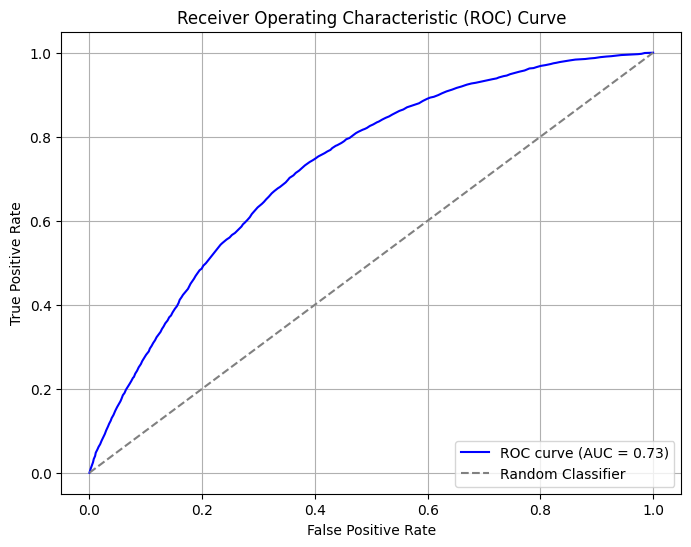

/var/folders/lf/bm_19l6x73l1h3__7m5px25h0000gn/T/ipykernel_80132/370781723.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_odds_ratios_sorted.values, y=state_odds_ratios_sorted.index.str.replace("state_", ""), palette='coolwarm')


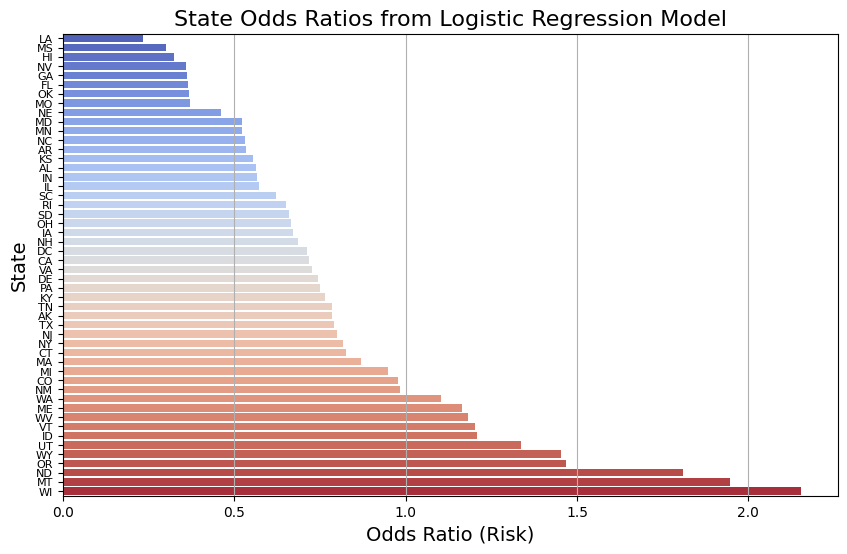

/var/folders/lf/bm_19l6x73l1h3__7m5px25h0000gn/T/ipykernel_80132/370781723.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_odds_ratios_sorted.values, y=season_odds_ratios_sorted.index.str.replace("season_", ""), palette='viridis')


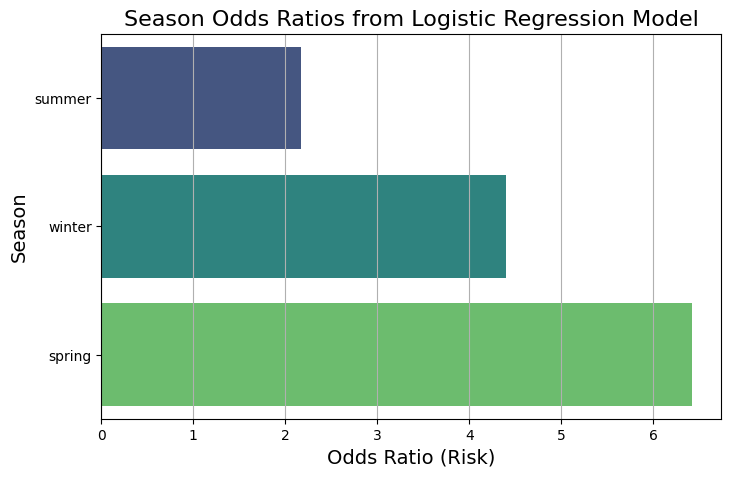

In [16]:
# measles, all years, arizona baseline state

X = measles_df[["state", "season"]]
y = measles_df["risk"]

# ensure Arizona is the baseline state by reordering the categories
X["state"] = X["state"].astype("category")  # Convert to categorical if not already
X["state"] = X["state"].cat.reorder_categories(
    ["AZ"] + [cat for cat in X["state"].cat.categories if cat != "AZ"],
    ordered=True
)

# encode state and season with Arizona as the baseline
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Convert target to binary
y_train_binary = y_train.map({'low': 0, 'high': 1}).astype(int)
y_test_binary = y_test.map({'low': 0, 'high': 1}).astype(int)

# Add constant to the predictors
X_train_with_const = sm.add_constant(X_train).astype(int)
X_test_with_const = sm.add_constant(X_test).astype(int)

# Fit logistic regression model
logit_model = sm.Logit(y_train_binary, X_train_with_const).fit()

# Model summary
logit_model.summary()

# Evaluation
# Predict probabilities on the test set
y_prob = logit_model.predict(X_test_with_const)

# Convert probabilities to binary predictions using 0.5 threshold
y_pred = (y_prob >= 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)
roc_auc = roc_auc_score(y_test_binary, y_prob)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Separate coefficients into states and seasons
coefficients = logit_model.params[1:]  # Exclude the constant term
state_coefficients = coefficients.filter(like="state")
season_coefficients = coefficients.filter(like="season")

# Calculate odds ratios
state_odds_ratios = np.exp(state_coefficients)
season_odds_ratios = np.exp(season_coefficients)

# Clean up labels for states (remove "state_" prefix)
state_labels = state_odds_ratios.index.str.replace("state_", "")

# Plot state odds ratios
state_odds_ratios_sorted = state_odds_ratios.sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=state_odds_ratios_sorted.values, y=state_odds_ratios_sorted.index.str.replace("state_", ""), palette='coolwarm')
plt.xlabel('Odds Ratio (Risk)', fontsize=14)
plt.ylabel('State', fontsize=14)
plt.title('State Odds Ratios from Logistic Regression Model', fontsize=16)
plt.tick_params(axis='y', labelsize=8)
plt.grid(axis='x')
plt.show()

# Clean up labels for seasons (if needed, remove "season_" prefix)
season_labels = season_odds_ratios.index.str.replace("season_", "")

# Plot season odds ratios
season_odds_ratios_sorted = season_odds_ratios.sort_values()
plt.figure(figsize=(8, 5))
sns.barplot(x=season_odds_ratios_sorted.values, y=season_odds_ratios_sorted.index.str.replace("season_", ""), palette='viridis')
plt.xlabel('Odds Ratio (Risk)', fontsize=14)
plt.ylabel('Season', fontsize=14)
plt.title('Season Odds Ratios from Logistic Regression Model', fontsize=16)
plt.grid(axis='x')
plt.show()
